In [2]:
"""
from OptimizedDataGenerator4 import *
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import keras_tuner as kt
noGPU=False
if noGPU:
    tf.config.set_visible_devices([], 'GPU')

print("\nHIIIIIIIIIIIIIIIIII\n")

print(tf.config.experimental.list_physical_devices())
print(tf.test.is_built_with_cuda())
print(tf.test.is_built_with_gpu_support())
print(tf.test.is_gpu_available())
"""

from abc import ABC, abstractmethod
# import all the necessary libraries
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Concatenate, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import PolynomialDecay, ExponentialDecay, CosineDecay
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import keras_tuner as kt
from sklearn.metrics import roc_curve, auc
from pathlib import Path
import os
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append("/local/d1/smartpixML/filtering_models/shuffling_data/") #TODO use the ODG from here
import OptimizedDataGenerator4_data_shuffled_bigData as ODG2
import pandas as pd
from datetime import datetime
sys.path.append("../ryan")
import OptimizedDataGenerator4 as ODG


sys.path.append(str(Path.cwd().parents[0]))

from MuC_Smartpix_ML.Model_Classes import SmartPixModel
print(SmartPixModel)

<class 'MuC_Smartpix_ML.Model_Classes.SmartPixModel'>


In [7]:
"""
from OptimizedDataGenerator4 import *
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import keras_tuner as kt
noGPU=False
if noGPU:
    tf.config.set_visible_devices([], 'GPU')

print("\nHIIIIIIIIIIIIIIIIII\n")

print(tf.config.experimental.list_physical_devices())
print(tf.test.is_built_with_cuda())
print(tf.test.is_built_with_gpu_support())
print(tf.test.is_gpu_available())
"""

from abc import ABC, abstractmethod
# import all the necessary libraries
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Concatenate, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import PolynomialDecay, ExponentialDecay, CosineDecay
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import keras_tuner as kt
from sklearn.metrics import roc_curve, auc
from pathlib import Path
import os
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append("/local/d1/smartpixML/filtering_models/shuffling_data/") #TODO use the ODG from here
import OptimizedDataGenerator4_data_shuffled_bigData as ODG2
import pandas as pd
from datetime import datetime
sys.path.append("../ryan")
import OptimizedDataGenerator4 as ODG


sys.path.append(str(Path.cwd().parents[0]))

from MuC_Smartpix_ML.Model_Classes import SmartPixModel
print(SmartPixModel)

class Model1(SmartPixModel):
    def __init__(self,
            tfRecordFolder: str = "/local/d1/smartpixML/filtering_models/shuffling_data/all_batches_shuffled_bigData_try2/filtering_records16384_data_shuffled_single_bigData/",
            nBits: list = None, # just for fractional bits, integer bits
                                ## number of bits is the number of bits for each quantized model and then
                                ## run training should make one model for each bit size
            loadModel: bool = False,
            modelPath: str = None, # Only include if you are loading a model
                        # dropout_rate: float = 0.1,
            initial_lr: float = 1e-3,
            end_lr: float = 1e-4,
            power: int = 2,
            bit_configs = [(16, 0), (8, 0), (6, 0), (4, 0), (3, 0), (2, 0)]  # Test 16, 8, 6, 4, 3, and 2-bit quantization
            ): 
        self.tfRecordFolder = tfRecordFolder
        self.modelName = "Model1" # for other models, e.g., Model 1, Model 2, etc.
        # self.model = None
        self.histories = {}
        self.models = {"Unquantized": None}
        self.bit_configs = bit_configs
        for total_bits, int_bits in self.bit_configs:
            config_name = f"quantized_{total_bits}w{int_bits}i"
            self.models[config_name] = None
        # self.quantized_model = None
        self.hyperparameterModel = None
        self.training_generator = None
        self.validation_generator = None
        self.x_feature_description: list = ['z_global','x_size', 'y_size', 'y_local']
        # Learning rate parameters
        self.initial_lr = initial_lr
        self.end_lr = end_lr
        self.power = power
        return
     
    def makeUnquantizedModel(self):
        ## here i will be making a 4-layer neural network 
        ## Model 1: z-global, x size, y size, y local


        ## define the inputs
        input1 = tf.keras.layers.Input(shape=(1,), name="z_global")
        input2 = tf.keras.layers.Input(shape=(1,), name="x_size")
        input3 = tf.keras.layers.Input(shape=(1,), name="y_size")
        input4 = tf.keras.layers.Input(shape=(1,), name="y_local")

        ## concatenate the inputs into one layer
        inputList = [input1, input2, input3, input4]
        inputs = tf.keras.layers.Concatenate()(inputList)


        ## here i will add the layers 

        stack1 = tf.keras.layers.Dense(17,activation='relu')(inputs)
        stack2 = tf.keras.layers.Dense(20, activation='relu')(stack1)
        stack3 = tf.keras.layers.Dense(9, activation='relu')(stack2)
        stack4 = tf.keras.layers.Dense(16, activation='relu')(stack3)
        stack5 = tf.keras.layers.Dense(18, activation='relu')(stack4)
        output = tf.keras.layers.Dense(1,activation='sigmoid')(stack5)

        self.models["Unquantized"] = tf.keras.Model(inputs=inputList, outputs=output)


    def makeUnquatizedModelHyperParameterTuning(self):
        def model_builder(hp):
            # ── B) Architecture hyperparams ──────────────────────────────────────────
            # separately tune rows and cols

            row1nodes      = hp.Int("1",   1, 30, step=1)
            row2nodes      = hp.Int("2",   1, 30, step=1)
            row3nodes      = hp.Int("3",   1, 30, step=1)
            row4nodes      = hp.Int("4",   1, 30, step=1)
            row5nodes      = hp.Int("5",   1, 30, step=1)



            input1 = tf.keras.layers.Input(shape=(1,), name="z_global")
            input2 = tf.keras.layers.Input(shape=(1,), name="x_size")
            input3 = tf.keras.layers.Input(shape=(1,), name="y_size")
            input4 = tf.keras.layers.Input(shape=(1,), name="y_local")

            ## concatenate the inputs into one layer
            inputList = [input1, input2, input3, input4]
            inputs = tf.keras.layers.Concatenate()(inputList)


            ## here i will add the layers 

            # layer 1
            x = tf.keras.layers.Dense(row1nodes,activation='relu')(inputs)
            x = tf.keras.layers.Dense(row2nodes, activation='relu')(x)
            x = tf.keras.layers.Dense(row3nodes, activation='relu')(x)
            x = tf.keras.layers.Dense(row4nodes, activation='relu')(x)
            x = tf.keras.layers.Dense(row5nodes, activation='relu')(x)
            output = tf.keras.layers.Dense(1,activation='sigmoid')(x)

            model = tf.keras.Model(inputs=inputList, outputs=output)

            model.compile(
            optimizer="adam",
            loss="binary_crossentropy",
            metrics=["binary_accuracy"],
            run_eagerly  = True 
            )
            return model

        tuner = kt.RandomSearch(
        model_builder, 
        objective           = "val_binary_accuracy",
        max_trials          = 120,
        executions_per_trial = 2,
        project_name        = "hp_search_1_30"
        )

        tuner.search(
            self.training_generator,
            validation_data = self.validation_generator,
            epochs          = 110,
            callbacks       = [
                EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
            ]
        )


    def makeUnquatizedModelHyperParameterTuning5(self):
        def model_builder(hp):
            # ── B) Architecture hyperparams ──────────────────────────────────────────
            # separately tune rows and cols

            rownodes      = hp.Int("1",   2, 11, step=1)
        
            input1 = tf.keras.layers.Input(shape=(1,), name="z_global")
            input2 = tf.keras.layers.Input(shape=(1,), name="x_size")
            input3 = tf.keras.layers.Input(shape=(1,), name="y_size")
            input4 = tf.keras.layers.Input(shape=(1,), name="y_local")

            ## concatenate the inputs into one layer
            inputList = [input1, input2, input3, input4]
            inputs = tf.keras.layers.Concatenate()(inputList)


            ## here i will add the layers 

            # layer 1
            x = tf.keras.layers.Dense(rownodes,activation='relu')(inputs)
            x = tf.keras.layers.Dense(rownodes, activation='relu')(x)
            x = tf.keras.layers.Dense(rownodes, activation='relu')(x)
            x = tf.keras.layers.Dense(rownodes, activation='relu')(x)
            x = tf.keras.layers.Dense(rownodes, activation='relu')(x)
            output = tf.keras.layers.Dense(1,activation='sigmoid')(x)

            model = tf.keras.Model(inputs=inputList, outputs=output)

            model.compile(
            optimizer="adam",
            loss="binary_crossentropy",
            metrics=["binary_accuracy"],
            run_eagerly  = True 
            )
            return model

        tuner = kt.RandomSearch(
        model_builder, 
        objective           = "val_binary_accuracy",
        max_trials          = 120,
        executions_per_trial = 2,
        project_name        = "hp_search_5rows"
        )

        tuner.search(
            self.training_generator,
            validation_data = self.validation_generator,
            epochs          = 110,
            callbacks       = [
                EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
            ]
        )

    def makeUnquatizedModelHyperParameterTuning4(self):
        def model_builder(hp):
            # ── B) Architecture hyperparams ──────────────────────────────────────────
            # separately tune rows and cols

            rownodes      = hp.Int("1",   2, 11, step=1)
        
            input1 = tf.keras.layers.Input(shape=(1,), name="z_global")
            input2 = tf.keras.layers.Input(shape=(1,), name="x_size")
            input3 = tf.keras.layers.Input(shape=(1,), name="y_size")
            input4 = tf.keras.layers.Input(shape=(1,), name="y_local")

            ## concatenate the inputs into one layer
            inputList = [input1, input2, input3, input4]
            inputs = tf.keras.layers.Concatenate()(inputList)


            ## here i will add the layers 

            # layer 1
            x = tf.keras.layers.Dense(rownodes,activation='relu')(inputs)
            x = tf.keras.layers.Dense(rownodes, activation='relu')(x)
            x = tf.keras.layers.Dense(rownodes, activation='relu')(x)
            x = tf.keras.layers.Dense(rownodes, activation='relu')(x)
            output = tf.keras.layers.Dense(1,activation='sigmoid')(x)

            model = tf.keras.Model(inputs=inputList, outputs=output)

            model.compile(
            optimizer="adam",
            loss="binary_crossentropy",
            metrics=["binary_accuracy"],
            run_eagerly  = True 
            )
            return model

        tuner = kt.RandomSearch(
        model_builder, 
        objective           = "val_binary_accuracy",
        max_trials          = 120,
        executions_per_trial = 2,
        project_name        = "hp_search_4rows"
        )

        tuner.search(
            self.training_generator,
            validation_data = self.validation_generator,
            epochs          = 110,
            callbacks       = [
                EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
            ]
        )


    def makeUnquatizedModelHyperParameterTuning3(self):
        def model_builder(hp):
            # ── B) Architecture hyperparams ──────────────────────────────────────────
            # separately tune rows and cols

            rownodes      = hp.Int("1",   2, 11, step=1)
        
            input1 = tf.keras.layers.Input(shape=(1,), name="z_global")
            input2 = tf.keras.layers.Input(shape=(1,), name="x_size")
            input3 = tf.keras.layers.Input(shape=(1,), name="y_size")
            input4 = tf.keras.layers.Input(shape=(1,), name="y_local")

            ## concatenate the inputs into one layer
            inputList = [input1, input2, input3, input4]
            inputs = tf.keras.layers.Concatenate()(inputList)


            ## here i will add the layers 

            # layer 1
            x = tf.keras.layers.Dense(rownodes,activation='relu')(inputs)
            x = tf.keras.layers.Dense(rownodes, activation='relu')(x)
            x = tf.keras.layers.Dense(rownodes, activation='relu')(x)
            output = tf.keras.layers.Dense(1,activation='sigmoid')(x)

            model = tf.keras.Model(inputs=inputList, outputs=output)

            model.compile(
            optimizer="adam",
            loss="binary_crossentropy",
            metrics=["binary_accuracy"],
            run_eagerly  = True 
            )
            return model

        tuner = kt.RandomSearch(
        model_builder, 
        objective           = "val_binary_accuracy",
        max_trials          = 120,
        executions_per_trial = 2,
        project_name        = "hp_search_3rows"
        )

        tuner.search(
            self.training_generator,
            validation_data = self.validation_generator,
            epochs          = 110,
            callbacks       = [
                EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
            ]
        )

    def makeUnquatizedModelHyperParameterTuning2(self):
        def model_builder(hp):
            # ── B) Architecture hyperparams ──────────────────────────────────────────
            # separately tune rows and cols

            rownodes      = hp.Int("1",   2, 11, step=1)
        
            input1 = tf.keras.layers.Input(shape=(1,), name="z_global")
            input2 = tf.keras.layers.Input(shape=(1,), name="x_size")
            input3 = tf.keras.layers.Input(shape=(1,), name="y_size")
            input4 = tf.keras.layers.Input(shape=(1,), name="y_local")

            ## concatenate the inputs into one layer
            inputList = [input1, input2, input3, input4]
            inputs = tf.keras.layers.Concatenate()(inputList)


            ## here i will add the layers 

            # layer 1
            x = tf.keras.layers.Dense(rownodes,activation='relu')(inputs)
            x = tf.keras.layers.Dense(rownodes, activation='relu')(x)
            output = tf.keras.layers.Dense(1,activation='sigmoid')(x)

            model = tf.keras.Model(inputs=inputList, outputs=output)

            model.compile(
            optimizer="adam",
            loss="binary_crossentropy",
            metrics=["binary_accuracy"],
            run_eagerly  = True 
            )
            return model

        tuner = kt.RandomSearch(
        model_builder, 
        objective           = "val_binary_accuracy",
        max_trials          = 120,
        executions_per_trial = 2,
        project_name        = "hp_search_2rows"
        )

        tuner.search(
            self.training_generator,
            validation_data = self.validation_generator,
            epochs          = 110,
            callbacks       = [
                EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
            ]
        )


        
    def makeQuantizedModel(self):
        for total_bits, int_bits in self.bit_configs:
            config_name = f"quantized_{total_bits}w{int_bits}i"
        
        
            print(f"Building {config_name} model...")
            self.makeQuantizedModel_withBits(total_bits=total_bits,int_bits=int_bits)

    def makeQuantizedModel_withBits(self, total_bits = 8,int_bits =0):
        """
        Build & compile your QKeras model with the given number of integer bits.
        """
        tf.keras.backend.clear_session()
        # inputs
        input1 = tf.keras.layers.Input(shape=(1,), name="z_global")
        input2 = tf.keras.layers.Input(shape=(1,), name="x_size")
        input3 = tf.keras.layers.Input(shape=(1,), name="y_size")
        input4 = tf.keras.layers.Input(shape=(1,), name="y_local")
        x = tf.keras.layers.Concatenate()([input1, input2, input3, input4])

        ## I want to try this with 1 int bit and 7 fractional
        ## I want to try this with 0 int bit and 7 fractional
        
        # layer 1
        x = QDense(
            17,
            kernel_quantizer=quantized_bits(total_bits, int_bits, alpha=1),
            bias_quantizer=quantized_bits(total_bits, int_bits, alpha=1),
            #kernel_regularizer=tf.keras.regularizers.L1L2(0.0001),
            ## adds sum of the activations squared to the loss function 
            #activity_regularizer=tf.keras.regularizers.L2(0.0001),
        )(x)
        x = QActivation(
            activation=quantized_relu(total_bits, int_bits),
            name="q_relu1"
        )(x)

        # layer 2 (example—you can tweak per‐layer bits)
        x = QDense(
            20,
            kernel_quantizer=quantized_bits(total_bits, int_bits, alpha=1),
            bias_quantizer=quantized_bits(total_bits, int_bits, alpha=1),
            #kernel_regularizer=tf.keras.regularizers.L1L2(0.0001),
            ## adds sum of the activations squared to the loss function 
            #activity_regularizer=tf.keras.regularizers.L2(0.0001),
        )(x)
        x = QActivation(
            activation=quantized_relu(total_bits, int_bits),
            name="q_relu2"
        )(x)

        # layer 3
        x = QDense(
            9,
            kernel_quantizer=quantized_bits(total_bits, int_bits, alpha=1),
            bias_quantizer=quantized_bits(total_bits, int_bits, alpha=1),
            #kernel_regularizer=tf.keras.regularizers.L1L2(0.0001),
            ## adds sum of the activations squared to the loss function 
            #activity_regularizer=tf.keras.regularizers.L2(0.0001),
        )(x)
        x = QActivation(
            activation=quantized_relu(total_bits, int_bits),
            name="q_relu3"
        )(x)

        # layer 4
        x = QDense(
            16,
            kernel_quantizer=quantized_bits(total_bits, int_bits, alpha=1),
            bias_quantizer=quantized_bits(total_bits, int_bits, alpha=1),
            #kernel_regularizer=tf.keras.regularizers.L1L2(0.0001),
            ## adds sum of the activations squared to the loss function 
            #activity_regularizer=tf.keras.regularizers.L2(0.0001),
        )(x)
        x = QActivation(
            activation=quantized_relu(total_bits, int_bits),
            name="q_relu4"
        )(x)

        # layer 5
        x = QDense(
            8,
            kernel_quantizer=quantized_bits(total_bits, int_bits, alpha=1),
            bias_quantizer=quantized_bits(total_bits, int_bits, alpha=1),
            #kernel_regularizer=tf.keras.regularizers.L1L2(0.0001),
            ## adds sum of the activations squared to the loss function 
            #activity_regularizer=tf.keras.regularizers.L2(0.0001),
        )(x)
        x = QActivation(
            activation=quantized_relu(total_bits, int_bits),
            name="q_relu5"
        )(x)

        # output
        x = QDense(
            1,
            kernel_quantizer=quantized_bits(total_bits, int_bits, alpha=1),
            bias_quantizer=quantized_bits(total_bits, int_bits, alpha=1),
            #kernel_regularizer=tf.keras.regularizers.L2(0.0001),
        )(x)
        out = QActivation("smooth_sigmoid")(x)
        config_name = f"quantized_{total_bits}w{int_bits}i"
        self.models[config_name] = tf.keras.Model(inputs=[input1, input2, input3, input4], outputs=out)


    def makeUnquatizedModelHyperParameterTuning2_final(self):
        input1 = tf.keras.layers.Input(shape=(1,), name="z_global")
        input2 = tf.keras.layers.Input(shape=(1,), name="x_size")
        input3 = tf.keras.layers.Input(shape=(1,), name="y_size")
        input4 = tf.keras.layers.Input(shape=(1,), name="y_local")

        ## concatenate the inputs into one layer
        inputList = [input1, input2, input3, input4]
        inputs = tf.keras.layers.Concatenate()(inputList)


        x = tf.keras.layers.Dense(2,activation='relu')(inputs)
        x = tf.keras.layers.Dense(2, activation='relu')(x)
        output = tf.keras.layers.Dense(1,activation='sigmoid')(x)

        model = tf.keras.Model(inputs=inputList, outputs=output)

        model.compile(
        optimizer="adam",
        loss="binary_crossentropy",
        metrics=["binary_accuracy"],
        run_eagerly  = True 
        )
        
        model.train()

<class 'MuC_Smartpix_ML.Model_Classes.SmartPixModel'>


In [8]:
m1 = Model1()                 # your subclass

m1.loadTfRecords()            # <-- IMPORTANT: load training/validation generators

m1.makeUnquatizedModelHyperParameterTuning2_final()

Loading training data from: /local/d1/smartpixML/filtering_models/shuffling_data/all_batches_shuffled_bigData_try2/filtering_records16384_data_shuffled_single_bigData//tfrecords_train/
Loading validation data from: /local/d1/smartpixML/filtering_models/shuffling_data/all_batches_shuffled_bigData_try2/filtering_records16384_data_shuffled_single_bigData//tfrecords_validation/
Using batch_size=16384 to match TFRecord format


Training generator length: 157
Validation generator length: 40


AttributeError: 'Functional' object has no attribute 'train'

2026-01-23 15:06:30.573400: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-01-23 15:06:30.615697: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-01-23 15:06:32.146175: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14174 MB memory:  -> device: 0, name: NVIDIA RTX A4000, pci bus id: 0000:4b:00.0, compute capability: 8.6


     trial  row1  row2  row3  row4  row5  params  val_accuracy
15      16     4     7     8     7     9     264      0.878204
17      18    16     2     7     3    11     215      0.878590
36      37     5    16     3    13    10     375      0.878483
56      57     4    11     3     1    30     206      0.872207
59      60    10     8     4     4     5     225      0.878325
71      72    29     4     4    24     3     484      0.879734
77      78     7    18     6     3    21     420      0.879044
81      82     8    17     2    22     8     488      0.878084
84      85    15     2     5    14     6     303      0.878740
90      91    23    10     6     3    11     498      0.879849
100    101     9     9     6     1    18     257      0.876827
112    113    15     7    25     2    14     496      0.879258


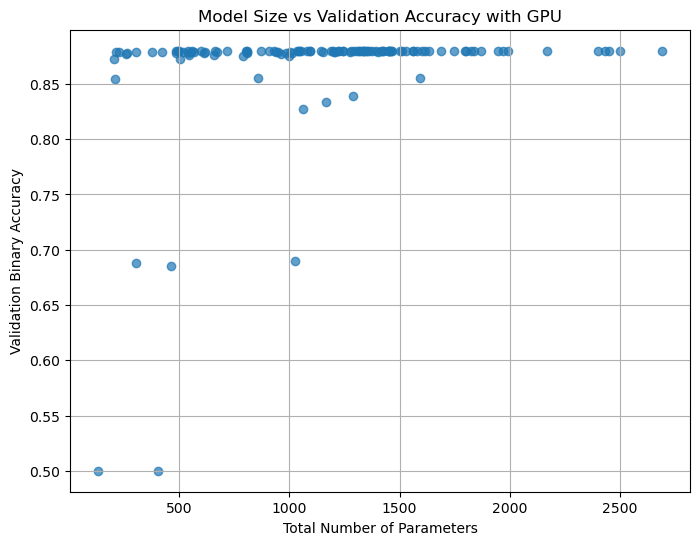

In [1]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf


base_dir = "/home/ryanmichaud/common_repo/Muon_Collider_Smart_Pixels/ryan/hp_search_1_30"

results = []

# helper: builds a model with these layer widths and counts params
def count_params_from_widths(r1):
    input1 = tf.keras.layers.Input(shape=(1,))
    input2 = tf.keras.layers.Input(shape=(1,))
    input3 = tf.keras.layers.Input(shape=(1,))
    input4 = tf.keras.layers.Input(shape=(1,))
    inputs = tf.keras.layers.Concatenate()([input1, input2, input3, input4])

    x = tf.keras.layers.Dense(r1, activation='relu')(inputs)
    x = tf.keras.layers.Dense(r2, activation='relu')(x)
    x = tf.keras.layers.Dense(r3, activation='relu')(x)
    x = tf.keras.layers.Dense(r4, activation='relu')(x)
    x = tf.keras.layers.Dense(r5, activation='relu')(x)
    out = tf.keras.layers.Dense(1, activation='sigmoid')(x)

    model = tf.keras.Model([input1,input2,input3,input4], out)
    return model.count_params()

# loop through all trial folders
for i in range(1, 120):
    trial_folder = os.path.join(base_dir, f"trial_{i:003d}")
    trial_json = os.path.join(trial_folder, "trial.json")

    if not os.path.exists(trial_json):
        continue

    with open(trial_json, "r") as f:
        data = json.load(f)

    hp_values = data["hyperparameters"]["values"]
    r1 = hp_values["1"]
    r2 = hp_values["2"]
    r3 = hp_values["3"]
    r4 = hp_values["4"]
    r5 = hp_values["5"]

    val_acc = data["metrics"]["metrics"]["val_binary_accuracy"]["observations"][0]["value"][0]

    # compute number of parameters
    total_params = count_params_from_widths(r1)

    results.append({
        "trial": i,
        "row1": r1,
        "row2": r2,
        "row3": r3,
        "row4": r4,
        "row5": r5,
        "params": total_params,
        "val_accuracy": val_acc
    })

df = pd.DataFrame(results)
"""
filtered = df[(df["val_accuracy"] > 0.87) & (df["params"] < 500)]
print(filtered)
"""

# --- PLOT PARAM COUNT VS ACCURACY ---
plt.figure(figsize=(8,6))
plt.scatter(df["params"], df["val_accuracy"], alpha=0.7)

plt.xlabel("Total Number of Parameters")
plt.ylabel("Validation Binary Accuracy")
plt.title("Model Size vs Validation Accuracy with GPU")
plt.grid(True)

plt.show()


2026-01-29 11:11:58.579384: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-01-29 11:11:58.619357: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-01-29 11:12:00.173556: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14173 MB memory:  -> device: 0, name: NVIDIA RTX A4000, pci bus id: 0000:4b:00.0, compute capability: 8.6


    rows  trial  row1  params  val_accuracy
0      2      0    11     199      0.878311
1      2      1     8     121      0.876393
2      2      2     5      61      0.871541
3      2      3     9     145      0.877919
4      2      4     7      99      0.877107
5      2      5     4      45      0.872245
6      2      6     2      19      0.868674
7      2      7    10     171      0.877941
8      2      8     3      31      0.869074
9      2      9     6      79      0.875367
10     3      0     3      43      0.685148
11     3      1     5      91      0.873748
12     3      2     4      65      0.871505
13     3      3     2      25      0.809222
14     3      4     8     193      0.878074
15     3      5    11     331      0.878764
16     3      6    10     281      0.878788
17     3      7     9     235      0.879206
18     3      8     7     155      0.875330
19     3      9     6     121      0.877021
20     4      0     9     325      0.878364
21     4      1     7     211   

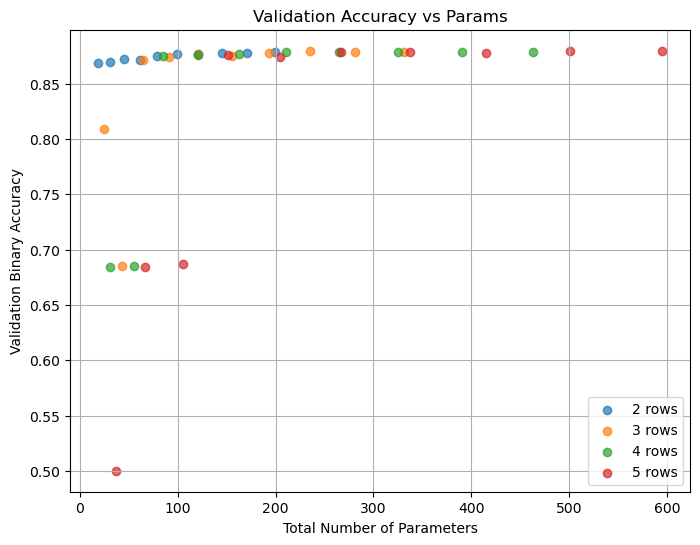

In [1]:
 import os
import json
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

BASE_ROOT = "/home/ryanmichaud/common_repo/Muon_Collider_Smart_Pixels/ryan"

results = []

def count_params_from_widthsr2(r1):
    input1 = tf.keras.layers.Input(shape=(1,))
    input2 = tf.keras.layers.Input(shape=(1,))
    input3 = tf.keras.layers.Input(shape=(1,))
    input4 = tf.keras.layers.Input(shape=(1,))
    inputs = tf.keras.layers.Concatenate()([input1, input2, input3, input4])

    x = tf.keras.layers.Dense(r1, activation='relu')(inputs)
    x = tf.keras.layers.Dense(r1, activation='relu')(x)
    out = tf.keras.layers.Dense(1, activation='sigmoid')(x)

    model = tf.keras.Model([input1,input2,input3,input4], out)
    return model.count_params()

def count_params_from_widthsr3(r1):
    input1 = tf.keras.layers.Input(shape=(1,))
    input2 = tf.keras.layers.Input(shape=(1,))
    input3 = tf.keras.layers.Input(shape=(1,))
    input4 = tf.keras.layers.Input(shape=(1,))
    inputs = tf.keras.layers.Concatenate()([input1, input2, input3, input4])

    x = tf.keras.layers.Dense(r1, activation='relu')(inputs)
    x = tf.keras.layers.Dense(r1, activation='relu')(x)
    x = tf.keras.layers.Dense(r1, activation='relu')(x)
    out = tf.keras.layers.Dense(1, activation='sigmoid')(x)

    model = tf.keras.Model([input1,input2,input3,input4], out)
    return model.count_params()

def count_params_from_widthsr4(r1):
    input1 = tf.keras.layers.Input(shape=(1,))
    input2 = tf.keras.layers.Input(shape=(1,))
    input3 = tf.keras.layers.Input(shape=(1,))
    input4 = tf.keras.layers.Input(shape=(1,))
    inputs = tf.keras.layers.Concatenate()([input1, input2, input3, input4])

    x = tf.keras.layers.Dense(r1, activation='relu')(inputs)
    x = tf.keras.layers.Dense(r1, activation='relu')(x)
    x = tf.keras.layers.Dense(r1, activation='relu')(x)
    x = tf.keras.layers.Dense(r1, activation='relu')(x)
    out = tf.keras.layers.Dense(1, activation='sigmoid')(x)

    model = tf.keras.Model([input1,input2,input3,input4], out)
    return model.count_params()

def count_params_from_widthsr5(r1):
    input1 = tf.keras.layers.Input(shape=(1,))
    input2 = tf.keras.layers.Input(shape=(1,))
    input3 = tf.keras.layers.Input(shape=(1,))
    input4 = tf.keras.layers.Input(shape=(1,))
    inputs = tf.keras.layers.Concatenate()([input1, input2, input3, input4])

    x = tf.keras.layers.Dense(r1, activation='relu')(inputs)
    x = tf.keras.layers.Dense(r1, activation='relu')(x)
    x = tf.keras.layers.Dense(r1, activation='relu')(x)
    x = tf.keras.layers.Dense(r1, activation='relu')(x)
    x = tf.keras.layers.Dense(r1, activation='relu')(x)
    out = tf.keras.layers.Dense(1, activation='sigmoid')(x)

    model = tf.keras.Model([input1,input2,input3,input4], out)
    return model.count_params()


# 🔁 LOOP OVER hp_search_1rows ... hp_search_5rows
for rows in range(1, 6):
    base_dir = os.path.join(BASE_ROOT, f"hp_search_{rows}rows")

    for i in range(0, 10):
        trial_folder = os.path.join(base_dir, f"trial_{i:003d}")
        trial_json = os.path.join(trial_folder, "trial.json")

        if not os.path.exists(trial_json):
            continue

        with open(trial_json, "r") as f:
            data = json.load(f)

        hp = data["hyperparameters"]["values"]
        r1 = r2 = r3 = r4 = r5 = hp["1"]

        val_acc = data["metrics"]["metrics"]["val_binary_accuracy"]["observations"][0]["value"][0]
        if rows == 2:
            params = count_params_from_widthsr2(r1)
        if rows == 3:
            params = count_params_from_widthsr3(r1)
        
        if rows == 4:
            params = count_params_from_widthsr4(r1)

        if rows == 5:
            params = count_params_from_widthsr5(r1)

        results.append({
            "rows": rows,
            "trial": i,
            "row1": r1,
            "params": params,
            "val_accuracy": val_acc
        })

df = pd.DataFrame(results)
print(df)


plt.figure(figsize=(8,6))
for rows in sorted(df["rows"].unique()):
    s = df[df["rows"] == rows]
    plt.scatter(s["params"], s["val_accuracy"], alpha=0.7, label=f"{rows} rows")

plt.xlabel("Total Number of Parameters")
plt.ylabel("Validation Binary Accuracy")
plt.title("Validation Accuracy vs Params")
plt.grid(True)
plt.legend()
plt.show()
